In [1]:
import os
import sys
sys.path.insert(1,os.path.abspath('../Git_Projects/0. Not_git/Sources/scikit-learn/0.23.2'))
import sklearn
print(sklearn.__version__)

0.23.2


### Import libraries

In [2]:
import pandas as pd
import plotly.express as px

from pycaret.regression import *

import plotly.io as pio

In [3]:
# To render plotly into GitHub
pio.renderers.default = "svg"

### Load Data

In [4]:
# Input path and filename
path = '../5. Master_thesis/Datasets/Output_files/'

# Load files into a pandas dataframes
file = path + '2.xlsx'
df = pd.concat(pd.read_excel(file, sheet_name=None), ignore_index=True)

# Dependant variable
dep_var = 'Orders' 

# Set index
df = df.set_index("Date").asfreq('MS')

In [6]:
df.head()

,Orders,CCI,CPI,Unemployment_rate,Long_term_interest_rates,Avg_Fuel_Price,TIV,Orders_rolled_detrended,TIV_rolled_detrended,Orders_lagged_12m
Date,,,,,,,,,,
2007-01-01,998,101.0667,2.302302,7.2,4.05,1.120000,18851,70.833333,5547.500000,1124
2007-02-01,638,100.9806,2.184707,7.2,4.08,1.133333,11852,-252.416667,-1368.750000,1079
2007-03-01,649,100.9416,2.574257,7.1,3.98,1.183333,14386,-194.666667,1230.000000,1210
2007-04-01,753,100.9870,2.561576,6.5,4.20,1.203333,13761,-57.833333,580.916667,1147
2007-05-01,856,100.9911,2.362205,6.6,4.33,1.236667,14917,57.250000,1870.166667,1001


### Split Data

In [7]:
# Split data
steps = 36  # Number of months of testing
train = df[:-steps]
test  = df[-steps:]

print(f"Dataset length : (n={len(df)})")
print(f"Train dates    : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates     : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

start = train.index.min()
end = df.index.max()
start_test = test.index.min()

start, end, start_test

Dataset length : (n=192)
Train dates    : 2007-01-01 00:00:00 --- 2019-12-01 00:00:00  (n=156)
Test dates     : 2020-01-01 00:00:00 --- 2022-12-01 00:00:00  (n=36)


(Timestamp('2007-01-01 00:00:00', freq='MS'),
 Timestamp('2022-12-01 00:00:00', freq='MS'),
 Timestamp('2020-01-01 00:00:00', freq='MS'))

### Pycaret

#### Initialize

In [8]:
# Initialize setup
s = setup(    
    data = train, 
    test_data = test, 
    target = dep_var, 
    preprocess=True,  
    fold_strategy = 'timeseries', 
    transform_target = False, 
    data_split_shuffle=False,
    session_id = 42)

,Description,Value
0,session_id,42
1,Target,Orders
2,Original Data,"(156, 10)"
3,Missing Values,0
4,Numeric Features,9
5,Categorical Features,0
6,Ordinal Features,0
7,High Cardinality Features,0
8,High Cardinality Method,None
9,Transformed Train Set,"(156, 9)"


In [9]:
# Review the transformed dataset
prep_pipe = get_config('prep_pipe') 
transformed_df = prep_pipe.transform(df) 

In [11]:
transformed_df

,CCI,CPI,Unemployment_rate,Long_term_interest_rates,Avg_Fuel_Price,TIV,Orders_rolled_detrended,TIV_rolled_detrended,Orders_lagged_12m
Date,,,,,,,,,
2007-01-01,101.066704,2.302302,7.2,4.050000,1.120000,18851.0,70.833336,5547.500000,1124.0
2007-02-01,100.980598,2.184707,7.2,4.080000,1.133333,11852.0,-252.416672,-1368.750000,1079.0
2007-03-01,100.941597,2.574257,7.1,3.980000,1.183333,14386.0,-194.666672,1230.000000,1210.0
2007-04-01,100.987000,2.561576,6.5,4.200000,1.203333,13761.0,-57.833332,580.916687,1147.0
2007-05-01,100.991096,2.362205,6.6,4.330000,1.236667,14917.0,57.250000,1870.166626,1001.0
...,...,...,...,...,...,...,...,...,...
2022-08-01,94.580208,7.616082,7.2,1.624904,2.153333,8163.0,-0.916667,369.500000,256.0
2022-09-01,94.107536,8.119296,7.3,2.420836,2.133333,7867.0,-24.333334,50.750000,259.0
2022-10-01,93.961418,8.310766,6.4,2.894486,2.136667,7132.0,-65.166664,-648.916687,178.0


In [12]:
transformed_df.columns

Index(['CCI', 'CPI', 'Unemployment_rate', 'Long_term_interest_rates',
       'Avg_Fuel_Price', 'TIV', 'Orders_rolled_detrended',
       'TIV_rolled_detrended', 'Orders_lagged_12m'],
      dtype='object')

In [13]:
df.columns

Index(['Orders', 'CCI', 'CPI', 'Unemployment_rate', 'Long_term_interest_rates',
       'Avg_Fuel_Price', 'TIV', 'Orders_rolled_detrended',
       'TIV_rolled_detrended', 'Orders_lagged_12m'],
      dtype='object')

#### Model comparison

In [14]:
# Train and evaluate models
exclude_list = ['dummy', 'br', 'knn', 'en', 'omp', 'huber', 'ridge', 'llar', 'lasso', 'lr', 'lar','par']
#exclude_list = []
best = compare_models(exclude = exclude_list, sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,81.6446,11601.8621,101.4219,0.4561,0.1828,0.1593,0.0450
xgboost,Extreme Gradient Boosting,89.3188,14514.6503,116.4145,0.3634,0.2070,0.1665,0.0270
gbr,Gradient Boosting Regressor,93.2671,15301.3875,116.9870,0.3041,0.2084,0.1796,0.0140
rf,Random Forest Regressor,95.3454,16261.2515,119.4576,0.2877,0.2116,0.1872,0.6310
ada,AdaBoost Regressor,97.9896,17008.4608,122.2074,0.3083,0.2185,0.1882,0.0220
lightgbm,Light Gradient Boosting Machine,121.2437,26289.4478,147.5375,-0.0950,0.2825,0.2736,0.2270
dt,Decision Tree Regressor,121.6071,26517.6071,154.5242,-0.1579,0.2899,0.2296,1.1510


#### Create best model

In [15]:
# Create model
model = create_model(best)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,155.3871,29758.9405,172.5078,0.0888,0.3992,0.4470
1,55.9593,4663.2640,68.2881,0.8008,0.1602,0.1395
2,103.7214,15798.5689,125.6924,0.2601,0.1851,0.1446
3,106.2721,19932.2152,141.1815,0.6849,0.2491,0.1662
4,71.4064,9602.8593,97.9942,-0.1751,0.1759,0.1420
5,84.1443,13550.5820,116.4070,0.6061,0.1638,0.1211
6,63.2629,4601.7489,67.8362,0.7895,0.1188,0.1022
7,46.5193,3732.0080,61.0902,0.7457,0.0873,0.0682
8,37.6279,3435.4869,58.6130,0.8915,0.0781,0.0562


#### Tune model

In [16]:
# Tune model
tuned_model = tune_model(model, n_iter=50, optimize = 'MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,164.3920,32778.5326,181.0484,-0.0036,0.4293,0.4872
1,55.8781,4560.1655,67.5290,0.8052,0.1740,0.1487
2,103.9874,16038.5248,126.6433,0.2488,0.1871,0.1444
3,107.5085,20892.7888,144.5434,0.6697,0.2354,0.1639
4,65.1188,9440.6101,97.1628,-0.1552,0.1761,0.1338
5,94.5509,20548.9933,143.3492,0.4027,0.1919,0.1314
6,57.4695,4023.8656,63.4339,0.8159,0.1024,0.0884
7,56.0265,4573.6491,67.6288,0.6884,0.0991,0.0833
8,44.5699,4007.4097,63.3041,0.8735,0.0894,0.0679


In [17]:
tuned_model

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=7, max_features=1.0, max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.2,
                    min_impurity_split=None, min_samples_leaf=2,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=280, n_jobs=-1, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)

In [18]:
model

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)

#### Plot model

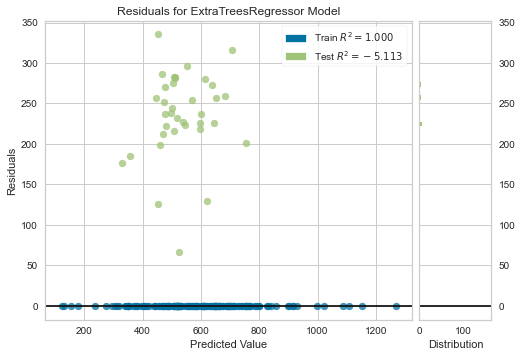

In [19]:
# PLot model - Residual plot
plot_model(model)

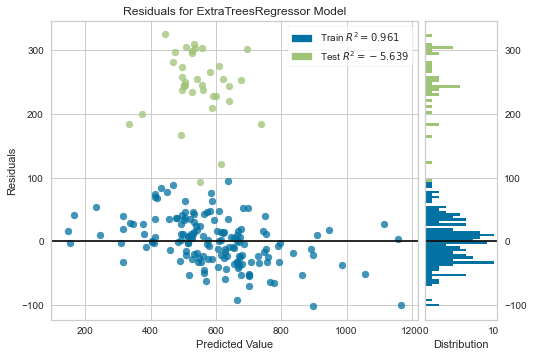

In [20]:
# PLot model - Residual plot
plot_model(tuned_model)

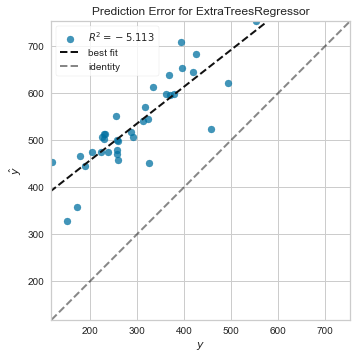

In [21]:
# Prediction Error Plot
plot_model(model, plot = 'error')

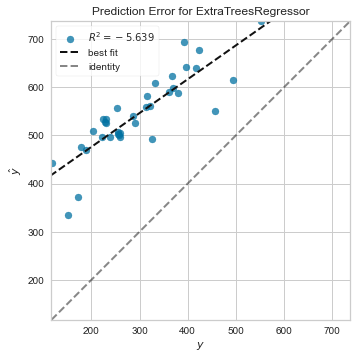

In [22]:
# Prediction Error Plot
plot_model(tuned_model, plot = 'error')

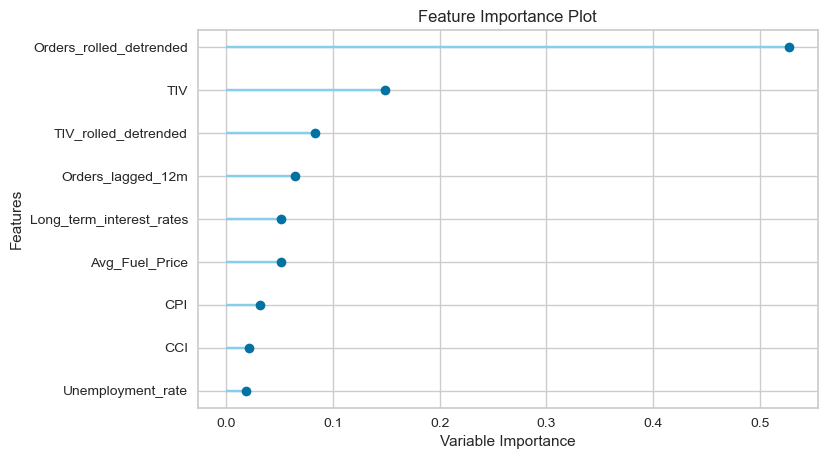

In [23]:
# Feature Importance Plot
plot_model(model, plot='feature')

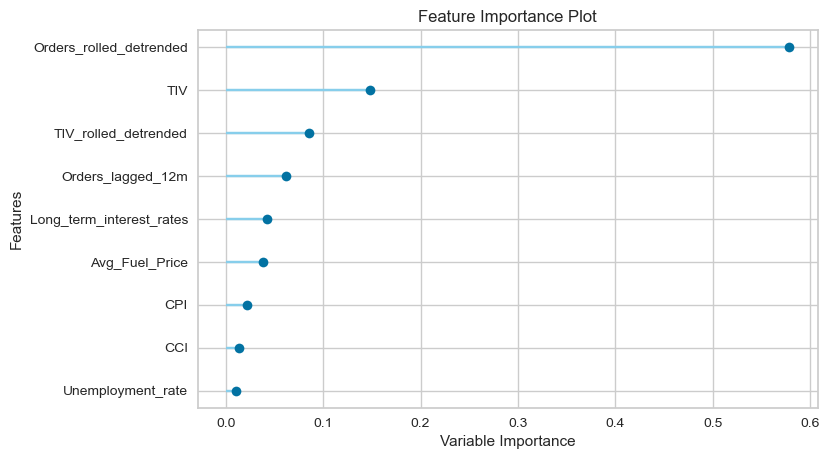

In [24]:
# Feature Importance Plot
plot_model(tuned_model, plot='feature')

#### Evaluate models

In [25]:
evaluate_model(model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [26]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

#### Predict on test set

In [27]:
prediction = predict_model(model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,236.1147,58529.2910,241.9283,-5.1130,0.6591,0.9140


In [28]:
prediction_tuned = predict_model(tuned_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,246.9630,63569.4805,252.1299,-5.6394,0.6828,0.9607


#### Predict full dataset

##### Base model

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,44.2715,10974.2421,104.7580,0.7528,0.2854,0.1714


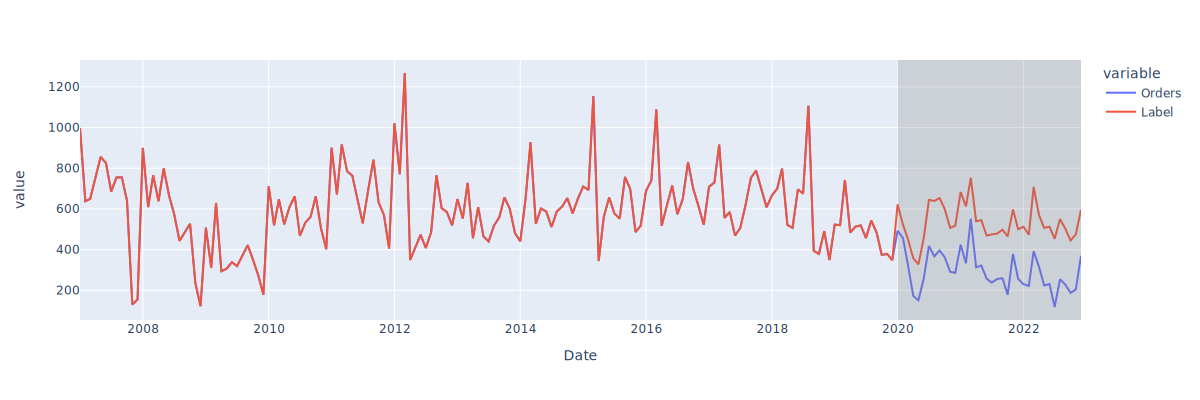

In [32]:
# Generate predictions on the original dataset
predictions = predict_model(model, data=df)

# Add a date column in the dataset
predictions['Date'] = pd.date_range(start=start, end = end, freq = 'MS')

# Line plot
fig = px.line(predictions, x='Date', y=[dep_var, "Label"]) #, template = 'plotly_dark')

# Add a vertical rectange for test-set separation
fig.add_vrect(x0=start_test, x1=predictions.Date.max(), fillcolor="grey", opacity=0.25, line_width=0)
fig.update_layout(height=400, width=1200)
fig.show()

##### Tuned model

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,70.3912,13057.2109,114.2682,0.7059,0.3033,0.2264


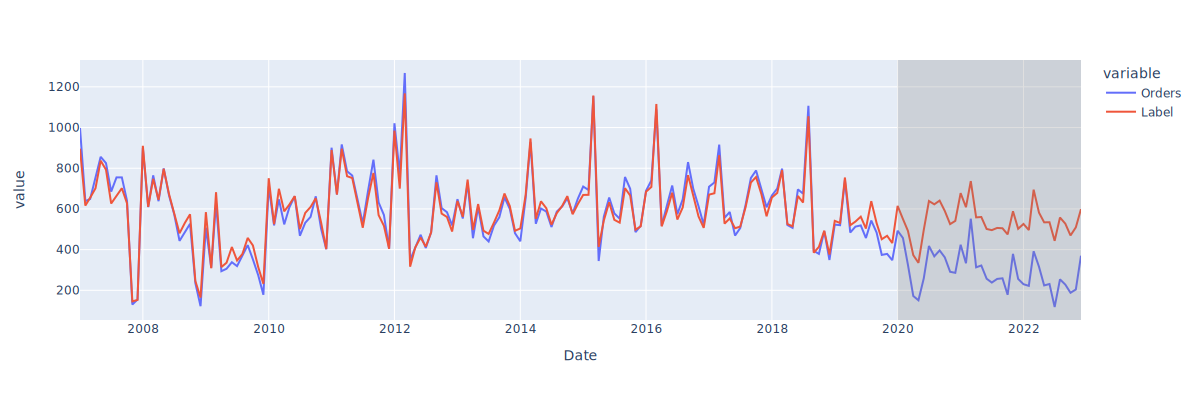

In [33]:
# Generate predictions on the original dataset
predictions = predict_model(tuned_model, data=df)

# Add a date column in the dataset
predictions['Date'] = pd.date_range(start=start, end = end, freq = 'MS')

# Line plot
fig = px.line(predictions, x='Date', y=[dep_var, "Label"]) #, template = 'plotly_dark')

# Add a vertical rectange for test-set separation
fig.add_vrect(x0=start_test, x1=predictions.Date.max(), fillcolor="grey", opacity=0.25, line_width=0)
fig.update_layout(height=400, width=1200)
fig.show()

#### Finalize model

In [34]:
# Finalize the model i.e. train the best model on the entire dataset (this time, including the test set).
final = finalize_model(tuned_model)

In [35]:
final

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=7, max_features=1.0, max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.2,
                    min_impurity_split=None, min_samples_leaf=2,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=280, n_jobs=-1, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)